In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import lib
from lib import data_dis, data_ref, data_vst

In [6]:
import numpy as np
from ksvd import ApproximateKSVD
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit

In [7]:
image = data_vst[0]

Text(0.5, 1.0, 'After ksvd')

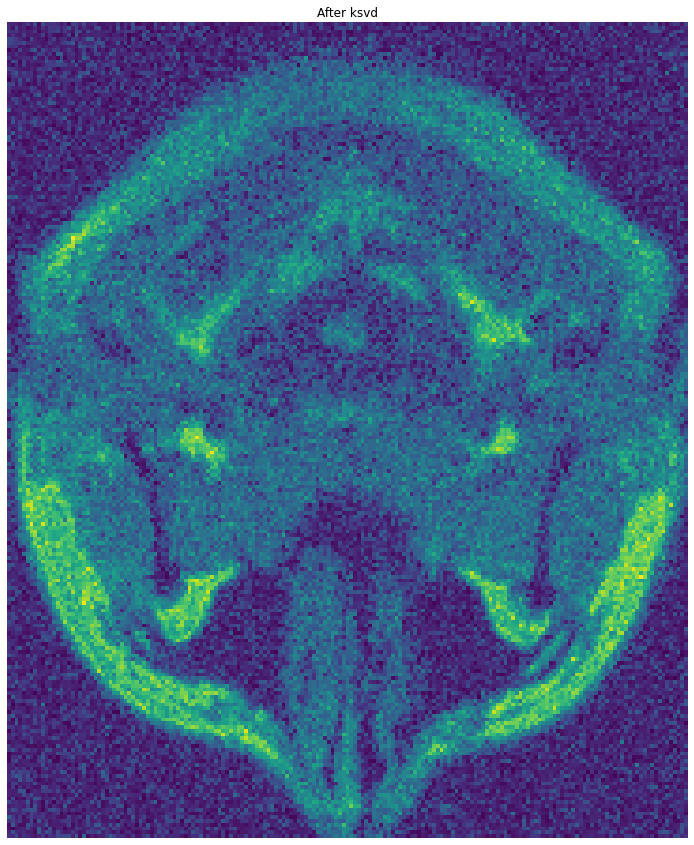

In [8]:
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.axis('off')
plt.title('After ksvd')
# plt.show()
# plt.savefig('results/1/1_vst.jpg')

In [14]:
# dictionary, alpha = lib.build_ksvd(lib.extract_patches_2d(image, (4, 4)).reshape(-1, 16), n_components=100, nonzero_fracttion=0.05)
dictionary, alpha  = lib.load_pickle('archive/dict_alpha_for_vst.pkl')

In [ ]:
# lib.dump_pickle((dictionary, alpha), 'dict_alpha)_for_vst.pkl')

In [15]:
alpha.shape

(38092, 100)

Text(0.5, 1.0, 'After ksvd')

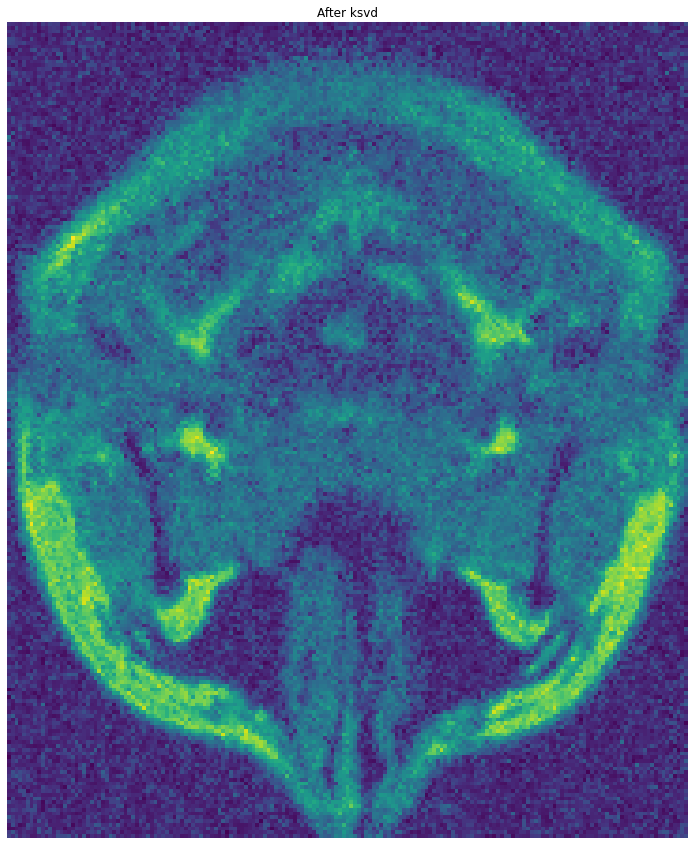

In [16]:
plt.figure(figsize=(15, 15))
plt.imshow(lib.reconstruct_from_patches_2d((alpha @ dictionary).reshape(-1, 4, 4), image.shape))
plt.axis('off')
# plt.show()
plt.title('After ksvd')
# plt.savefig('results/1/2_ksvd.jpg')

In [17]:
dictionary.shape, alpha.shape

((100, 16), (38092, 100))

In [18]:
weighted_dict = lib.make_weighted_dict(dictionary, alpha, delta=2)

Text(0.5, 1.0, 'After weighting atoms')

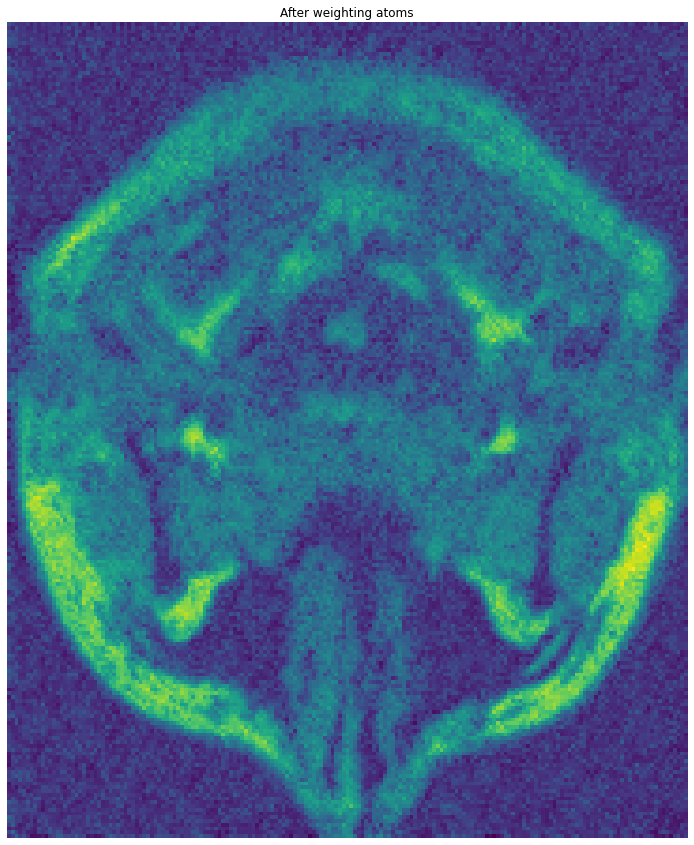

In [19]:
plt.figure(figsize=(15, 15))
plt.imshow(lib.reconstruct_from_patches_2d((alpha @ weighted_dict).reshape(-1, 4, 4), image.shape))
plt.axis('off')
# plt.show()
plt.title('After weighting atoms')
# plt.savefig('results/1/3_weigting.jpg')

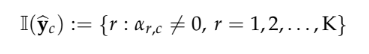

In [20]:
I = []
for i in range(len(alpha)):
    I.append(np.nonzero(alpha[i])[0])
len(I), I[0]

(38092, array([ 7, 12, 65, 83, 95]))

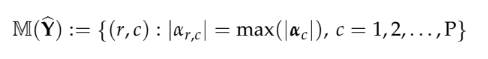

In [21]:
M = np.argmax(alpha, axis=1)
M

array([ 7,  7,  7, ..., 35,  2,  7])

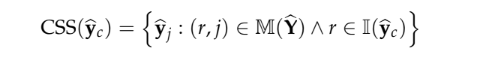

In [ ]:
def calc_css(alpha):
    CSS = np.zeros((alpha.shape[1], alpha.shape[0]), dtype='int') - 1
    pos = np.zeros(alpha.shape[1], dtype='int')

    for index in range(alpha.shape[1]):
        for j in range(alpha.shape[0]):
            if alpha[j][index] != 0:
                CSS[index, pos[index]] = j
                pos[index] += 1
    return CSS, pos

In [ ]:
CSS, length = calc_css(alpha)

In [ ]:
CSS.shape

(100, 38092)

In [22]:
reduced = alpha @ weighted_dict

In [23]:
I = {}
for i,row in enumerate(reduced):
    I[i] = []
    for j in range(weighted_dict.shape[0]):
        if alpha[i,j]!=0:
            I[i].append(j)    

In [25]:
M={}
for i in I:
    if len(I[i])==0:
        M[i] = None
    else:
        M[i]= abs(alpha[I[i]]).argmax()

In [ ]:
CSS={}
for i in tqdm(I):
    CSS[i] = []
    if len(I[i])==0:
        continue
    for j in M:
        if M[j] in I[i]:
            CSS[i].append(j)

In [ ]:
from numba import njit

@jit(nopython=True)
def calc_cc(CSS, length, M, alpha, a=0.06, b=0.18, gamma=0, max_elems=1000):
    out = np.zeros((alpha.shape[0], max_elems), dtype='int')
    pos = np.zeros(alpha.shape[0], dtype='int')
    for i in (range(alpha.shape[0])):
    # for i in range(100):
        if i % 10 == 0:
            print(i, alpha.shape[0], i / alpha.shape[0] * 100)
        max_elem_id = M[i]
        for tmp in range(length[max_elem_id]):
            j = CSS[max_elem_id][tmp]
            yc = alpha[i]
            yj = alpha[j]
            if np.linalg.norm(yj - yc) / np.linalg.norm(yc) <= \
                (b - a * np.linalg.norm(yc) / np.linalg.norm(np.ones_like(yc))) * (1 + gamma):
                
                if pos[i] < max_elems:
                    out[i, pos[i]] = j
                    pos[i] += 1
    return out, pos

In [ ]:
%%time
out = calc_cc(CSS, length, M, alpha)
out

In [ ]:
indices = out[0][0, 0: out[1][0]]

In [ ]:
patch = (alpha @ weighted_dict)[indices]

In [ ]:
U, S, Vt = np.linalg.svd(patch, full_matrices=False)
# S[10:] = 0
patch = U * S @ Vt
patch = patch.mean(axis=0)

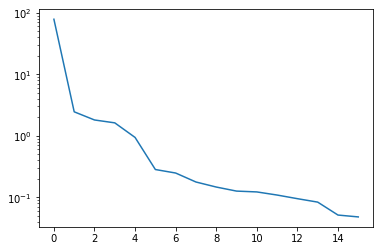

In [ ]:
plt.plot(S)
plt.yscale('log')

In [ ]:
patch.shape

(16,)

In [ ]:
dictionary.shape

(100, 16)

In [ ]:
def svd_and_average(dict, alpha, appr_indices, appr_len):
    TRUNCATE_SVD = 8
    image = alpha @ dict
    image_new = image.copy()
    for i in tqdm(range(len(alpha))):
        indices = appr_indices[i, 0: appr_len[i]]
        patch = image[indices]
        U, S, Vt = np.linalg.svd(patch, full_matrices=False)
        S[TRUNCATE_SVD:] = 0
        patch = U * S @ Vt
        patch = patch.mean(axis=0)
    return image_new

image_svd = svd_and_average(dictionary, alpha, *out)

100%|██████████| 38092/38092 [00:06<00:00, 6217.11it/s]


Text(0.5, 1.0, 'After nonlocal filtering')

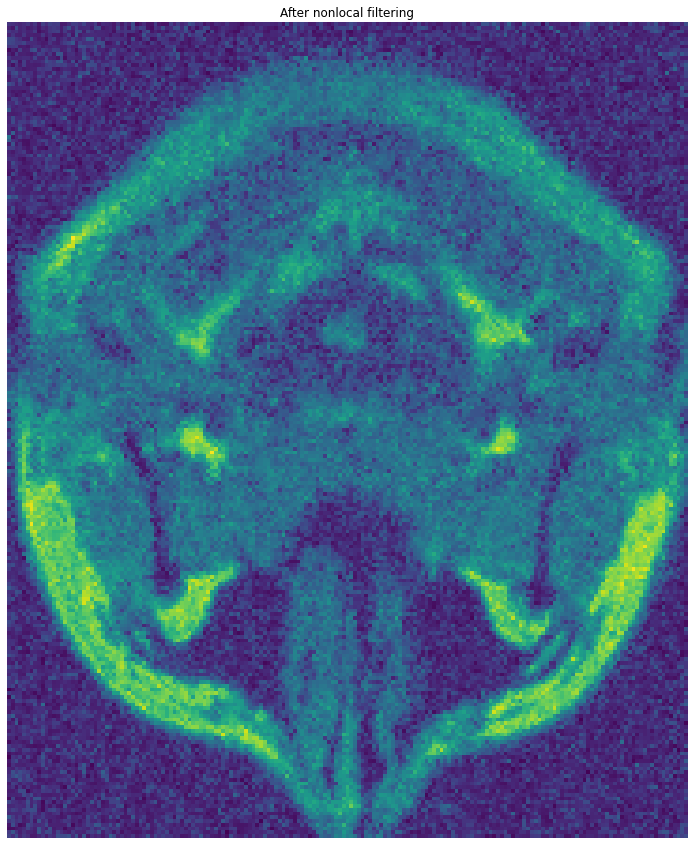

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(lib.reconstruct_from_patches_2d((image_svd).reshape(-1, 4, 4), image.shape))
plt.axis('off')
plt.title('After nonlocal filtering')
# plt.show()
# plt.savefig('results/1/4_nonlocal.jpg')